In [182]:
import tracker as tr
import ect
import cv2
import matplotlib.pyplot as plt
import numpy as np

radius = 200

transformer = tr.FilteredTransformation(
    img_offset = radius/20,
    ect_offset = radius/10,
    radius = radius
)

loader = tr.FilepathLoader(
    radius = radius,
    offset = radius/20
)

matcher = tr.CorrelationMatcher(
    transformer = transformer
)

template = "../sample_imgs/black_e_big.png"
image = "../sample_imgs/e_3.png"
noise = "../sample_imgs/whitenoise.png"
# base = np.zeros((400, 400, 3), np.uint8)
# template = np.zeros_like(base)
# template[270:330, 270:330, :] = 255
# template[290:310, 290:310, :] = 0

# image = np.zeros_like(base)
# image[250:280, 250:280, :] = 255
# image[260:270, 260:270, :] = 0

Text(0.5, 1.0, 'image ect')

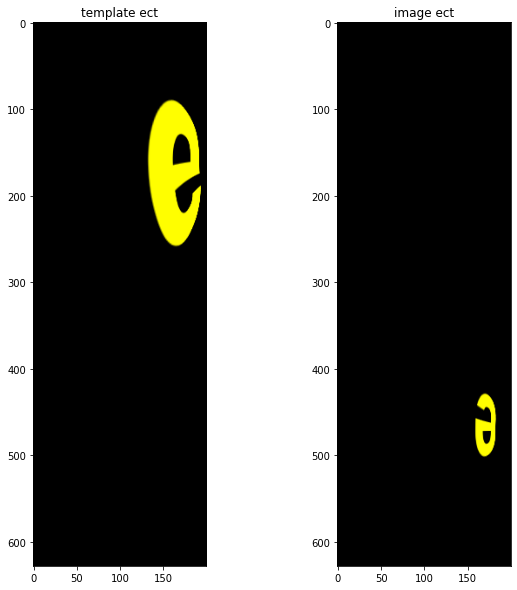

In [183]:
template_ect = loader.load(template)
# print(loader.filepath)
image_ect = loader.load(image)
# noise_ect = loader.load(noise)

# image_ect += noise_ect
# print(loader.filepath)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(template_ect))
plt.title("template ect")

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(image_ect))
plt.title("image ect")

Text(0.5, 1.0, 'image ect')

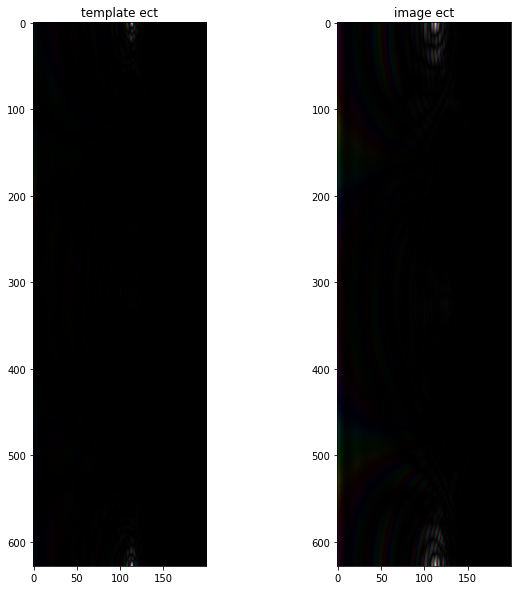

In [184]:

template_ect = transformer.transform(template_ect)

image_ect = transformer.transform(image_ect)

sidelobe = ect.sidelobe(image_ect.shape[:2], offset=40)

# image_ect = image_ect * sidelobe
# template_ect = template_ect * sidelobe

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(template_ect))
plt.title("template ect")

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(image_ect))
plt.title("image ect")

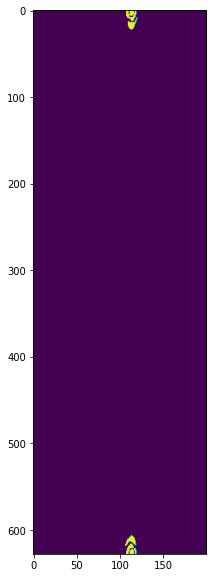

In [185]:
thresh = 0.1
template_abs = ect.norm_minmax(np.abs(template_ect), 0, 1, dtype=np.float64)

bp_filter = np.zeros_like(template_abs)
bp_filter[template_abs > thresh] = 1

plt.figure(figsize=(10, 10))
plt.imshow(bp_filter)

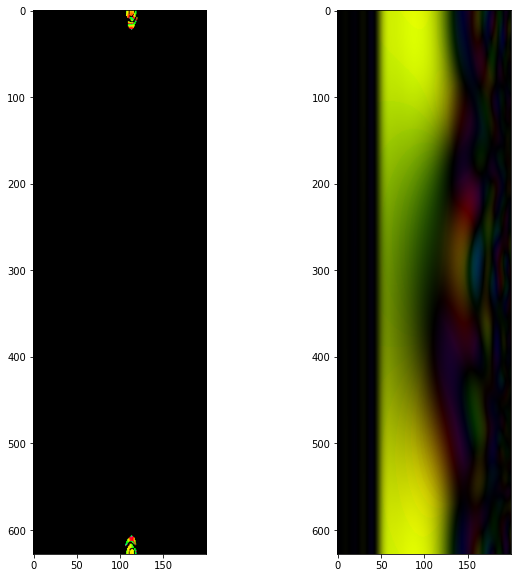

In [186]:
# calculate phase shift
ir = np.real(image_ect)
ii = np.imag(image_ect)
tr = np.real(template_ect)
ti = np.imag(template_ect)

phase = (ir*ti - ii*tr)/(ii*ti + tr*ir + 10e-12)
# xx = (ir*ti - ii*tr)
# yy = (ii*ti + tr*ir)

diss_xcorr = np.exp(1j*np.arctan(phase)) * bp_filter

diss_result = transformer.invert(diss_xcorr)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ect.complex_to_hsv(diss_xcorr))

plt.subplot(1, 2, 2)
plt.imshow(ect.complex_to_hsv(diss_result))

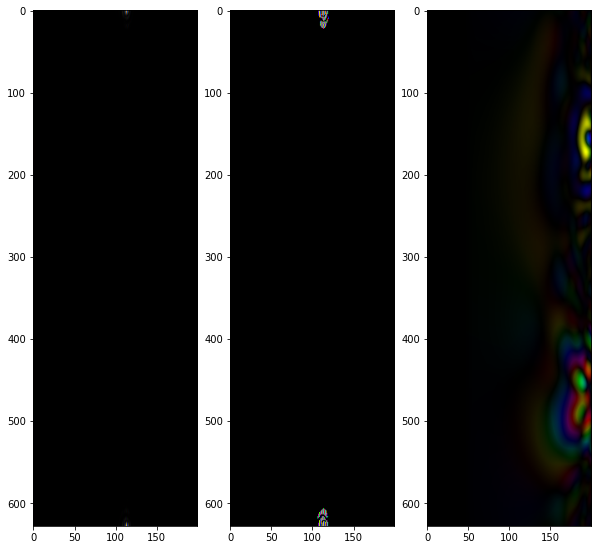

In [187]:
# image_tr = np.fft.fft2(image_ect)
# template_tr = np.fft.fft2(template_ect)


# xcorr = image_ect * np.conj(template_ect)
xcorr = np.conj(image_ect) * template_ect
# xcorr = image_tr * np.conj(template_tr)
xcorr_norm = xcorr/(np.abs(xcorr) + 1e-12) * bp_filter

# xcorr_inv = transformer.invert(xcorr)

xcorr_inv = transformer.invert(xcorr_norm)
# xcorr_inv = np.fft.ifft2(xcorr_norm)


plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(ect.complex_to_hsv(xcorr))

plt.subplot(1, 3, 2)
plt.imshow(ect.complex_to_hsv(xcorr_norm))

plt.subplot(1, 3, 3)
plt.imshow(ect.complex_to_hsv(xcorr_inv))

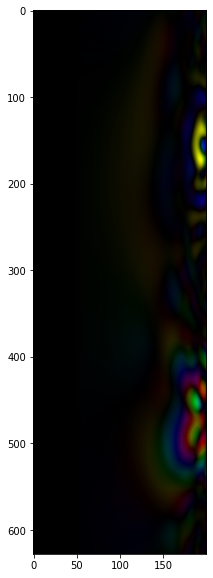

In [188]:
# match_result = np.real(xcorr_inv)

plt.figure(figsize=(10, 10))
plt.imshow(ect.complex_to_hsv(xcorr_inv))


In [189]:
idx = np.argmax(np.abs(xcorr_inv))
p, r = np.unravel_index(idx, xcorr_inv.shape[:2])

print(f"{p=}, {r=}, {xcorr_inv[p, r, 0]=:.2f}")

p=171, r=192, xcorr_inv[p, r, 0]=202157.16-7635.88j


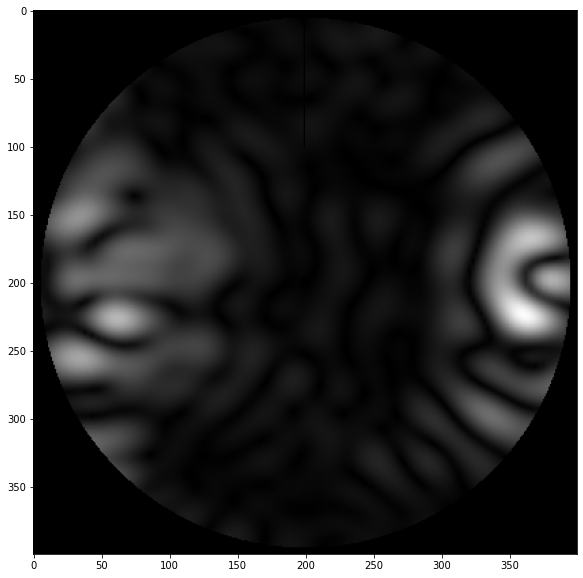

In [190]:
result = ect.ilogpolar(
    ect.norm_minmax(np.abs(xcorr_inv), 0, 255),
    # ect.complex_to_hsv(diss_result),
    offset=0
)

plt.figure(figsize=(10, 10))
plt.imshow(result)